# Assignment 2

This assignment was submitted to the class of 2021/1 for the course MO444 - Introduction to Machine Learning at Universidade Estadual de Campinas.

Its goal is to implement a regression system using the Gradient Descent algorithm and apply a classifying algorithm over digits dataset.

This notebook is better visualized on Colab, where helpers and unimportant sections are hidden. 

**Authors**
- Jonathan Nunes  
  146667  
  <j146667@dac.unicamp.br>

  Contributions:
  - Part I

- Lucas David  
  188972  
  <lucas.david@ic.unicamp.br>

  Contributions:
  - Part II

**Instructions**

1. Set the variable `Config.cluster_dat.source` to point to a valid location of the `cluster.dat` file.
2. If your file is in your Google Drive, make sure to run cell `6` and authenticate with your Google account.

**Links**
- Colab: https://colab.research.google.com/drive/1TbEJQr2O8EE0L-GoZkXtppHwoV2xUXf-

In [ ]:
import numpy as np
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [ ]:
class Config:
  class kicks:
    path = '/content/drive/MyDrive/datasets/MO444/assignment-2/'

    epochs = 1000

    search_learning_rates = [.1, .2, .5, .9, 1., 1.1, 1.2, 1.5, 2.0]
    search_repeats = 10
    lr = 1.

    search_degrees = [2, 3]
    poly_degree = 3

  class digits:
    test_size = 0.1  # 10%
    test_seed = 847

    reducer_components = 0.99
    search_scoring = 'f1_macro'    
    search_jobs = -1

    estimators = [
      dict(
        model_cls=LinearSVC,
        search_splits=2,
        search_repeats=50,
        search_params={
          'C': np.logspace(-5, 1, 10),
          'dual': [False]
        }
      ),
      dict(
        model_cls=RandomForestClassifier,
        search_splits=2,
        search_repeats=50,
        search_params={
          'n_estimators': [10, 50, 100, 200],
          'max_depth': [None, 3, 5],
        }
      )
    ]
  
  class run:
    seed = 1023812
    palette = sns.color_palette("husl", 3)

## Setup

In [ ]:
if 'google.colab' in str(get_ipython()):
  import shutil
  from google.colab import drive
  
  drive.mount('/content/drive')

  shutil.copy(Config.kicks.path + 'kick1.dat', './')
  shutil.copy(Config.kicks.path + 'kick2.dat', './')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
np.random.seed((Config.run.seed//4 + 41) * 3)

In [ ]:
from math import ceil

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
sns.set()
sns.set_palette(Config.run.palette)

In [ ]:
from matplotlib.colors import ListedColormap

CMAP = ListedColormap(sns.color_palette("husl", 256).as_hex())

In [ ]:
def normalize(x, axis=-1):
  x = x - x.min(axis=axis, keepdims=True)
  x /= x.max(axis=axis, keepdims=True)

  return x

In [ ]:
def visualize_images(
    image,
    title=None,
    rows=2,
    cols=None,
    cmap=None,
    figsize=(14, 6)
):
  if image is not None:
    if isinstance(image, list) or len(image.shape) > 3:  # many images
      plt.figure(figsize=figsize)
      cols = cols or ceil(len(image) / rows)
      for ix in range(len(image)):
        plt.subplot(rows, cols, ix+1)
        visualize_images(
          image[ix],
          cmap=cmap,
          title=title[ix] if title is not None and len(title) > ix else None)
      plt.tight_layout()
      return

    if image.shape[-1] == 1: image = image[..., 0]
    plt.imshow(image, cmap=cmap)
  
  if title is not None: plt.title(title)
  plt.axis('off')


def plot_trajectory(k, ax):
  sc = ax.scatter(k.x, k.y, k.z, s=40, marker='o')
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  l = len(k) -1
  x0 = (k.x[0], k.y[0], k.z[0])
  v = (k.x[l], k.y[l], k.z[l])
  ax.quiver(
      *x0,
      v[0] -x0[0], v[1] -x0[1], v[2] -x0[2],
      color = 'red', alpha = .8, lw = 1, length=0.1)

## Part I

### Kick 1 and 2 Datasets

In [ ]:
COLUMNS = 'x y z time'.split()

def load_kick(filename):
  k = np.genfromtxt(filename)
  t = ((np.arange(len(k)) + 1) * (1/60)).reshape(-1, 1)
  k = np.concatenate((k, t), axis=1)
  return pd.DataFrame(k, columns=COLUMNS)

k1, k2 = map(load_kick, ('kick1.dat', 'kick2.dat'))

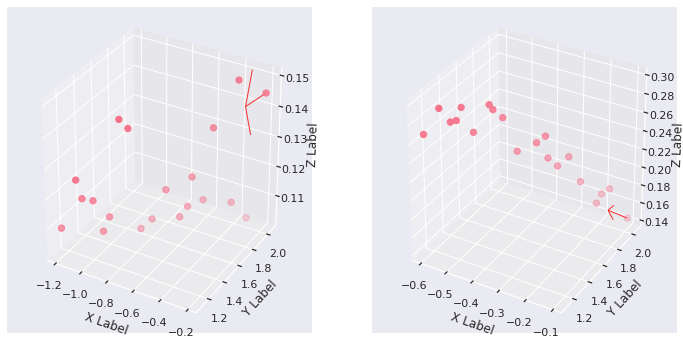

In [ ]:
#@title Sampled measurements in datasets Kick 1 & 2

plt.figure(figsize=(12, 6))
ax = plt.subplot(121, projection='3d')
plot_trajectory(k1, ax)

ax = plt.subplot(122, projection='3d')
plot_trajectory(k2, ax)

### Linear Regression

A linear regression model can be interpreted as affine transformation $f$ from observable features $x$ into the variable of interest $y$:

\begin{align}
f(x)&: \mathbb R \to R \\
f(x) &= x \cdot w + b
\end{align}

Subjected to $\text{argmin}_{w,c} \text{error}(f(x), y)$.

In the formulation above, $w$ correspond to the angular coefficient vector, while $b$ corresponds to the linear coefficient, intercept or bias factor.

In [ ]:
def linear_regression(x, w):
  return x @ w

We employ *mean squared error* as our cost function:

$J(x, y, \theta)=\frac{1}{2m}\sum_{i=0}^m[p_i-y_i]^2$

Where:

* $x=\{x_1,x_2,\ldots,x_n\}$ is a set of observed features
* $y=\{y_1, y_2,\ldots,y_m\}$ is the set of paired measurements being regressed
* $\theta$ is the set of parameters of the model

In [ ]:
def mse(y, h):
  return np.average((h - y)**2, axis=0) / 2

Our objective is optimize (minimize) the cost function, for this purpose we use **gradient descent**. Main step:

\begin{align}
\theta_j &:= \theta_j-\alpha\frac{\partial}{\partial\theta_j}J(x,y,\theta) \\
         &= \theta_j-\alpha\frac{\partial }{\partial\theta_j} \frac{1}{2m}\sum_{i=0}^m[p_i-y_i]^2 \\
         &= \theta_j-\alpha \frac{1}{m} \sum_i^m (p_i-y_i)x_i \\
\end{align}

In [ ]:
def gradient_descent(
    x,
    y,
    w,
    lr,
    epochs,
    verbose=1,
    report_every=100):
  m = x.shape[0]
  history = []

  for step in range(epochs):
    p = linear_regression(x, w)

    loss = mse(y, p)
    djdp = p - y
    djdw = (1/m) * (x.T @ djdp)
    w = w - lr * djdw

    history.append(loss)

    if verbose > 0 and (not step % report_every or step == epochs-1):
      print(f'  Step={step+1:04d} MSE={loss}')

  return w, history

### Regression of The Ball $(x,y,z)$-Position Based on Time

For simplicity, we opted by implicitly representing the bias factor within $w$. This can be accomplished by concatenating the $1$ vector to the input features.

In [ ]:
def learn_kicks(x, y, lr, epochs, verbose=1):
  samples, features = x.shape
  targets = y.shape[1]

  w0 = np.random.randn(features, targets)

  if verbose > 1:
    params = (('lr', lr),
              ('epochs', epochs),
              ('features', features),
              ('targets', targets),
              ('w0', w0.ravel().round(1)))

    print('Learning kicks dataset', *(f'{k.ljust(8)}={v}' for k, v in params), sep='\n  ')

  w, history = gradient_descent(x, y, w0, lr, epochs, verbose - 1)

  if verbose > 1:
    print(f'  w       ={w.ravel().round(2)}')

  return w, history


def linear_time_features(k):
  x = k.time.values.reshape(-1, 1)
  x = np.hstack((np.ones((len(k), 1)), x))

  y = k.drop('time', axis=1).values

  return x, y

#### Searching

In [ ]:
def search_lr(x, y, rates, repeats):
  reports = []

  for lr in rates:
    report = pd.DataFrame([
     learn_kicks(x, y, lr, Config.kicks.epochs, verbose=0)[1][-1]
     for r in range(repeats)
    ], columns=[f'loss {i}' for i in range(y.shape[1])])
    
    report['total_loss'] = report.sum(axis=1)
    report['repeat'] = np.arange(repeats)
    report['lr'] = lr
    reports.append(report)

  return pd.concat(reports)

In [ ]:
report = pd.concat((
  search_lr(*linear_time_features(k1), Config.kicks.search_learning_rates, Config.kicks.search_repeats).assign(dataset='kick 1'),
  search_lr(*linear_time_features(k2), Config.kicks.search_learning_rates, Config.kicks.search_repeats).assign(dataset='kick 2')
))

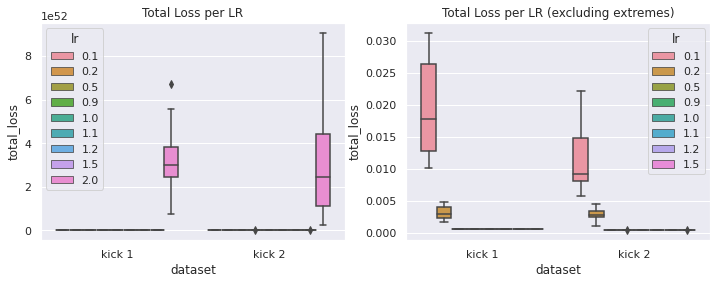

In [ ]:
#@title Impact of LR over Linear Regression

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('Total Loss per LR')
sns.boxplot(data=report, x='dataset', y='total_loss', hue='lr')

plt.subplot(122)
plt.title('Total Loss per LR (excluding extremes)')
sns.boxplot(data=report[~report.lr.isin((2,))], x='dataset', y='total_loss', hue='lr')
plt.tight_layout();

In [ ]:
(report
 .groupby(['dataset', 'lr'], as_index=False)
 .mean()
 .pivot('lr', 'dataset', 'total_loss'))

dataset,kick 1,kick 2
lr,,
0.1,1.944908e-02,1.147106e-02
0.2,3.059766e-03,2.835703e-03
0.5,5.279857e-04,3.340128e-04
0.9,5.133297e-04,3.267812e-04
1.0,5.133205e-04,3.267764e-04
1.1,5.133192e-04,3.267753e-04
1.2,5.133190e-04,3.267752e-04
1.5,5.133190e-04,3.267752e-04
2.0,3.336092e+52,3.299281e+52


Small learning rates such as 0.1 and 0.2 produced underfitted results, while the ones closer to 1 (e.g. 1., 1.2 and 1.5) produced the best ones.
These results could most likely also be obtained by the lower learning rates by increasing the number of epochs.

Setting `lr=2` resulted in a diverging optimization process (MSE has increased in the order of $10^{52}$).

#### Training

In [ ]:
best_lr_l1 = (
  report[report.dataset == 'kick 1']
  .groupby('lr')
  .mean()
  .total_loss
  .idxmin())

In [ ]:
%%time

x, y = linear_time_features(k1)
w1, lh1 = learn_kicks(x, y, best_lr_l1, Config.kicks.epochs, verbose=2)

Learning kicks dataset
  lr      =1.5
  epochs  =1000
  features=2
  targets =3
  w0      =[-0.5  1.7  0.1 -1.  -2.9  0.5]
  Step=0001 MSE=[0.02059184 0.08114489 0.00191246]
  Step=0101 MSE=[1.60383456e-03 6.24151886e-05 1.77976749e-04]
  Step=0201 MSE=[4.41837839e-04 5.77237882e-05 1.02666615e-04]
  Step=0301 MSE=[3.64212396e-04 5.74103862e-05 9.76356348e-05]
  Step=0401 MSE=[3.59026745e-04 5.73894499e-05 9.72995477e-05]
  Step=0501 MSE=[3.58680325e-04 5.73880512e-05 9.72770959e-05]
  Step=0601 MSE=[3.58657183e-04 5.73879578e-05 9.72755961e-05]
  Step=0701 MSE=[3.58655637e-04 5.73879516e-05 9.72754959e-05]
  Step=0801 MSE=[3.58655534e-04 5.73879512e-05 9.72754892e-05]
  Step=0901 MSE=[3.58655527e-04 5.73879511e-05 9.72754888e-05]
  Step=1000 MSE=[3.58655526e-04 5.73879511e-05 9.72754887e-05]
  w       =[-0.21  2.1   0.12 -2.97 -2.99 -0.03]
CPU times: user 35.5 ms, sys: 1.85 ms, total: 37.3 ms
Wall time: 38.3 ms


In [ ]:
best_lr_l2 = (
  report[report.dataset == 'kick 2']
  .groupby('lr')
  .mean()
  .total_loss
  .idxmin())

In [ ]:
%%time

x, y = linear_time_features(k2)
w2, lh2 = learn_kicks(x, y, best_lr_l2, Config.kicks.epochs, verbose=2)

Learning kicks dataset
  lr      =1.5
  epochs  =1000
  features=2
  targets =3
  w0      =[-0.8 -1.  -0.9 -0.2  0.3  0.6]
  Step=0001 MSE=[0.11583133 3.28245168 0.51374024]
  Step=0101 MSE=[0.00066271 0.00444015 0.00017678]
  Step=0201 MSE=[0.00015942 0.00035017 0.00014805]
  Step=0301 MSE=[1.25799024e-04 7.69469375e-05 1.46132377e-04]
  Step=0401 MSE=[1.23553001e-04 5.86945598e-05 1.46004177e-04]
  Step=0501 MSE=[1.23402959e-04 5.74752372e-05 1.45995613e-04]
  Step=0601 MSE=[1.23392936e-04 5.73937821e-05 1.45995041e-04]
  Step=0701 MSE=[1.23392266e-04 5.73883407e-05 1.45995003e-04]
  Step=0801 MSE=[1.23392221e-04 5.73879771e-05 1.45995000e-04]
  Step=0901 MSE=[1.23392218e-04 5.73879529e-05 1.45995000e-04]
  Step=1000 MSE=[1.23392218e-04 5.73879512e-05 1.45995000e-04]
  w       =[-0.11  2.1   0.16 -1.47 -2.99  0.44]
CPU times: user 39.3 ms, sys: 1.83 ms, total: 41.1 ms
Wall time: 42.3 ms


#### Evaluation

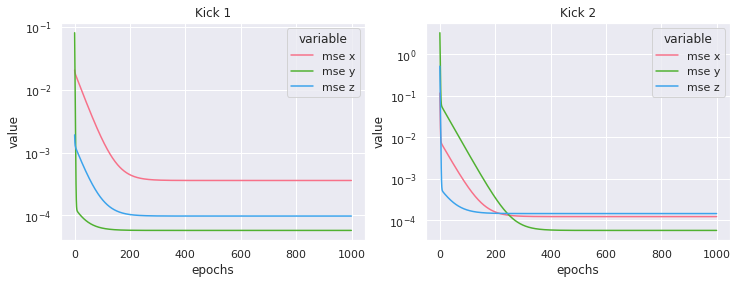

In [ ]:
#@title Loss over training (log scale)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('Kick 1')
g = sns.lineplot(
  data=pd.DataFrame(lh1, columns=['mse x', 'mse y', 'mse z']).assign(epochs=np.arange(len(lh1))).melt('epochs', ['mse x', 'mse y', 'mse z']),
  x='epochs', y='value', hue='variable')
g.set(yscale='log')

plt.subplot(122)
plt.title('Kick 2')
g = sns.lineplot(
  data=pd.DataFrame(lh2, columns=['mse x', 'mse y', 'mse z']).assign(epochs=np.arange(len(lh2))).melt('epochs', ['mse x', 'mse y', 'mse z']),
  x='epochs', y='value', hue='variable')
g.set(yscale='log');

In [ ]:
%%time

x = ((np.arange(60) + 1) * (1/60)).reshape(-1, 1)
x = np.hstack((np.ones((len(x), 1)), x))

p1l = linear_regression(x, w1)
p2l = linear_regression(x, w2)

CPU times: user 254 µs, sys: 0 ns, total: 254 µs
Wall time: 201 µs


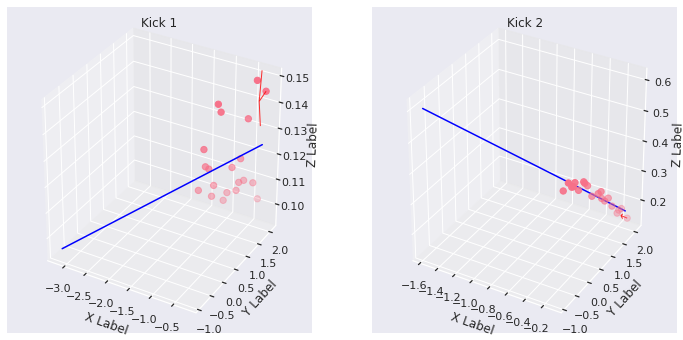

In [ ]:
#@title Kick 1 & 2 Samples and Estimated Trajectory

plt.figure(figsize=(12, 6))
ax = plt.subplot(121, projection='3d')
plt.title('Kick 1')
plot_trajectory(k1, ax)
sc = ax.plot(*p1l.T, c='blue')

ax = plt.subplot(122, projection='3d')
plt.title('Kick 2')
plot_trajectory(k2, ax)
sc = ax.plot(*p2l.T, c='blue')

### Linear Regression with Polynomial Features

In [ ]:
import itertools


def feature_combinations(features, degree, bias):
  """Generate a list of all possible n^degree associations between column features in the data.
  
  Arguments
  ---------
  features: int
    the number of input features (already including bias)
  degree: int
    the degree of the polynomial fn generated
  bias: bool
    whether or not the polynomial should include a bias factor.
    This will be used to determine the correct name of the features.

  Return
  ------
  set of tuple of indices
    Example: `{(0), (1), (0,0), (1,1), (0,1), (0,0,0), (0,0,1), (0,1,1), (1,1,1)]`
  list of feature names
    Example: `['bias', 'x1', 'x0x0', ..., 'x1x1x1']`

  """
  features = np.arange(features)
  combinations = {tuple(sorted(terms)) for terms in itertools.product(features, repeat=degree)}
  feature_names = [''.join(((f'x{t}' if t != 0 or not bias else '')
                            for t in terms)) or 'bias'
                   for terms in combinations]

  return combinations, feature_names


def polynomial_features(x, degree=2, bias=True):
  """Generate a new dataset containing the terms in the degree-polynomial as columns/features.
  
  Arguments
  ---------
  x: 2d array-like
    the input data
  degree: int
    the degree of the polynomial fn generated
  bias: bool
    whether or not the polynomial should include a bias factor=1.
    If True, this will add a column containing 1s to the data beforehand.
    The polynomial terms will then contain all associations with cardinality less-or-equal than `degree`
    ({x0*bias*bias, x0*x0*bias, ..., x0*x1*bias, ..., x1*x1*x1} = {x0, x0*x0, ..., x0*x1, ..., x1*x1*x1}).

    If false, only associations with cardinality strictly equal to `degree` will be generated
    ({x0*x0*x0, x0*x0*x1, x0*x1*x1, x1*x1*x1}).

  Return
  ------
  set of tuple of indices
    Example: `{(0), (1), (0,0), (1,1), (0,1), (0,0,0), (0,0,1), (0,1,1), (1,1,1)]`
  list of feature names
    Example: `['bias', 'x1', 'x0x0', ..., 'x1x1x1']`

  """
  if isinstance(x, pd.DataFrame): x = x.values
  if bias: x = np.hstack((np.ones((x.shape[0], 1)), x))

  combinations, feature_names = feature_combinations(x.shape[1], degree, bias)
  z = np.empty((x.shape[0], len(combinations)))

  for ix, terms in enumerate(combinations):
    z[:, ix] = np.prod(x[:, terms], axis=1)

  return z, feature_names


def polynomial_time_features(k, degree=2):
  x = k.time.values.reshape(-1, 1)
  x, _ = polynomial_features(x, degree=degree)

  y = k.drop('time', axis=1).values

  return x, y

In [ ]:
#@title Example: features=time degree=3 bias=True
z, feature_names = polynomial_features(k1[['time']], degree=3)
pd.DataFrame(z, columns=feature_names).head()

,x1x1,x1x1x1,bias,x1
0,0.000278,0.000005,1.0,0.016667
1,0.001111,0.000037,1.0,0.033333
2,0.002500,0.000125,1.0,0.050000
3,0.004444,0.000296,1.0,0.066667
4,0.006944,0.000579,1.0,0.083333


#### Searching

In [ ]:
from sklearn.model_selection import ParameterGrid

def search(k, rates, degrees, repeats, verbose=1):
  params = ParameterGrid({'lr': rates, 'degree': degrees})

  reports = []

  for p in params:
    if verbose > 0: print(f'Evaluating config {p}')

    x, y = polynomial_time_features(k, degree=p['degree'])
    report = pd.DataFrame([
     learn_kicks(x, y, p['lr'], Config.kicks.epochs, verbose=0)[1][-1]
     for r in range(repeats)
    ], columns=[f'loss {i}' for i in range(y.shape[1])])
    
    report['total_loss'] = report.sum(axis=1)
    report['repeat'] = np.arange(repeats)
    for n, v in p.items(): report[n] = v
    reports.append(report)

  return pd.concat(reports)

In [ ]:
%%time

report = pd.concat((
  search(k1, Config.kicks.search_learning_rates, Config.kicks.search_degrees, Config.kicks.search_repeats, verbose=0).assign(dataset='kick 1'),
  search(k2, Config.kicks.search_learning_rates, Config.kicks.search_degrees, Config.kicks.search_repeats, verbose=0).assign(dataset='kick 2'),
))

CPU times: user 16.7 s, sys: 51.1 ms, total: 16.8 s
Wall time: 16.8 s


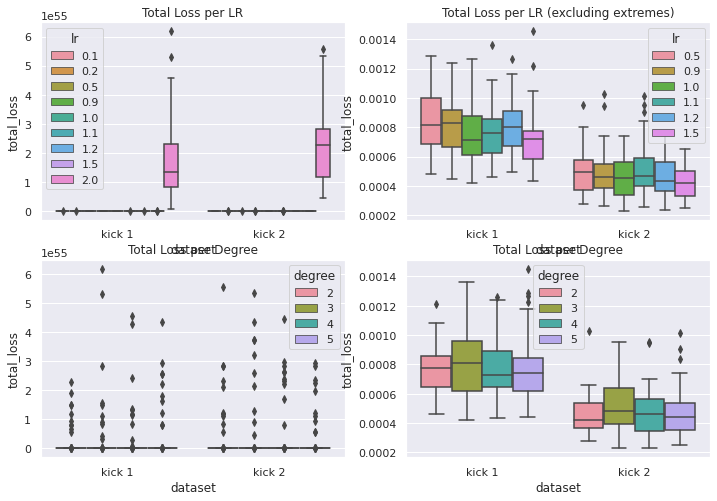

In [ ]:
#@title Impact of LR and Degree over Polynomial Regression

plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Total Loss per LR')
sns.boxplot(data=report, x='dataset', y='total_loss', hue='lr')

plt.subplot(222)
plt.title('Total Loss per LR (excluding extremes)')
sns.boxplot(data=report[~report.lr.isin((.1, .2, 2))], x='dataset', y='total_loss', hue='lr')

plt.subplot(223)
plt.title('Total Loss per Degree')
sns.boxplot(data=report, x='dataset', y='total_loss', hue='degree')

plt.subplot(224)
plt.title('Total Loss per Degree')
sns.boxplot(data=report[~report.lr.isin((.1, .2, 2))], x='dataset', y='total_loss', hue='degree')
plt.tight_layout();

In [ ]:
(report
 .groupby(['dataset', 'degree', 'lr'], as_index=False)
 .mean()
 .pivot(['dataset', 'degree'], 'lr', 'total_loss'))

lr                   0.1       0.2       0.5  ...       1.2       1.5           2.0
dataset degree                                ...                                  
kick 1  2       0.018322  0.002700  0.000817  ...  0.000788  0.000664  1.211806e+55
        3       0.016052  0.002482  0.000895  ...  0.000833  0.000690  2.091931e+55
        4       0.012421  0.002626  0.000731  ...  0.000785  0.000734  1.744877e+55
        5       0.014379  0.002910  0.000919  ...  0.000848  0.000775  2.078914e+55
kick 2  2       0.009768  0.001696  0.000473  ...  0.000479  0.000419  2.052530e+55
        3       0.008448  0.002091  0.000573  ...  0.000534  0.000417  2.769026e+55
        4       0.010158  0.001728  0.000517  ...  0.000419  0.000428  2.489753e+55
        5       0.010080  0.002125  0.000422  ...  0.000426  0.000441  1.669180e+55

[8 rows x 9 columns]

#### Training

In [ ]:
best_lr_p1, best_d_p1 = (
  report[report.dataset == 'kick 1']
  .groupby(['lr', 'degree'])
  .mean()
  .total_loss
  .idxmin())

print('best params found:')
print(f'  lr    ={best_lr_p1}')
print(f'  degree={best_d_p1}')

best params found:
  lr    =1.5
  degree=2


In [ ]:
%%time

x, y = polynomial_time_features(k1, best_d_p1)
w1, ph1 = learn_kicks(x, y, best_lr_p1, Config.kicks.epochs, verbose=2)

Learning kicks dataset
  lr      =1.5
  epochs  =1000
  features=3
  targets =3
  w0      =[-1.1  1.1 -0.6  0.6 -0.7  0.2  0.8  0.  -0.5]
  Step=0001 MSE=[0.75137886 2.27442334 0.00476931]
  Step=0101 MSE=[0.00117015 0.00462641 0.000238  ]
  Step=0201 MSE=[0.00037605 0.00033511 0.00011207]
  Step=0301 MSE=[0.0003367  0.00012851 0.00010581]
  Step=0401 MSE=[0.00033352 0.00011757 0.00010529]
  Step=0501 MSE=[0.00033209 0.00011603 0.00010504]
  Step=0601 MSE=[0.00033077 0.00011495 0.00010482]
  Step=0701 MSE=[0.00032948 0.00011392 0.00010459]
  Step=0801 MSE=[0.00032822 0.0001129  0.00010437]
  Step=0901 MSE=[0.00032697 0.0001119  0.00010416]
  Step=1000 MSE=[0.00032576 0.00011093 0.00010395]
  w       =[-3.08 -2.57  0.04 -0.2   2.07  0.12  0.31 -1.19 -0.2 ]
CPU times: user 35.9 ms, sys: 1e+03 ns, total: 36 ms
Wall time: 35.3 ms


In [ ]:
best_lr_p2, best_d_p2 = (
  report[report.dataset == 'kick 2']
  .groupby(['lr', 'degree'])
  .mean()
  .total_loss
  .idxmin())

print('best params found:')
print(f'  lr    ={best_lr_p1}')
print(f'  degree={best_d_p1}')

best params found:
  lr    =1.5
  degree=2


In [ ]:
%%time

x, y = polynomial_time_features(k2, best_d_p2)
w2, ph2 = learn_kicks(x, y, best_lr_p2, Config.kicks.epochs, verbose=2)

Learning kicks dataset
  lr      =1.0
  epochs  =1000
  features=3
  targets =3
  w0      =[ 0.2  1.3  0.4 -0.1 -0.9  1.2 -0.4  0.  -1.2]
  Step=0001 MSE=[0.05671032 2.51156101 0.4881078 ]
  Step=0101 MSE=[0.00162282 0.01375747 0.00029977]
  Step=0201 MSE=[0.00038407 0.00193331 0.00010602]
  Step=0301 MSE=[2.18866512e-04 3.65036512e-04 8.02770164e-05]
  Step=0401 MSE=[1.95994972e-04 1.56420085e-04 7.68032916e-05]
  Step=0501 MSE=[1.92004428e-04 1.28063809e-04 7.62830315e-05]
  Step=0601 MSE=[1.90528457e-04 1.23613342e-04 7.61550336e-05]
  Step=0701 MSE=[1.89397194e-04 1.22340396e-04 7.60797458e-05]
  Step=0801 MSE=[1.88322841e-04 1.21496883e-04 7.60121448e-05]
  Step=0901 MSE=[1.87267107e-04 1.20718385e-04 7.59462532e-05]
  Step=1000 MSE=[1.86235147e-04 1.19964061e-04 7.58819162e-05]
  w       =[-1.2  -2.54  0.83 -0.12  2.07  0.14 -0.77 -1.29 -1.1 ]
CPU times: user 35.7 ms, sys: 0 ns, total: 35.7 ms
Wall time: 36.1 ms


#### Evaluation

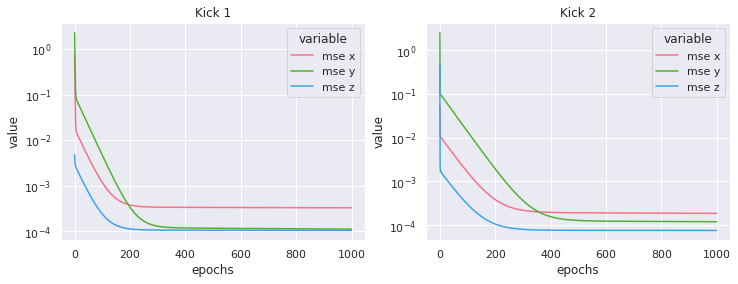

In [ ]:
#@title Loss over training (log scale)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('Kick 1')
g = sns.lineplot(
  data=pd.DataFrame(ph1, columns=['mse x', 'mse y', 'mse z']).assign(epochs=np.arange(len(ph1))).melt('epochs', ['mse x', 'mse y', 'mse z']),
  x='epochs', y='value', hue='variable')
g.set(yscale='log')

plt.subplot(122)
plt.title('Kick 2')
g = sns.lineplot(
  data=pd.DataFrame(ph2, columns=['mse x', 'mse y', 'mse z']).assign(epochs=np.arange(len(ph2))).melt('epochs', ['mse x', 'mse y', 'mse z']),
  x='epochs', y='value', hue='variable')
g.set(yscale='log');

In [ ]:
%%time

x = ((np.arange(60) + 1) * (1/60)).reshape(-1, 1)
x1, _ = polynomial_features(x, degree=best_d_p1)
x2, _ = polynomial_features(x, degree=best_d_p2)

p1p = linear_regression(x1, w1)
p2p = linear_regression(x2, w2)

CPU times: user 710 µs, sys: 1 µs, total: 711 µs
Wall time: 2.48 ms


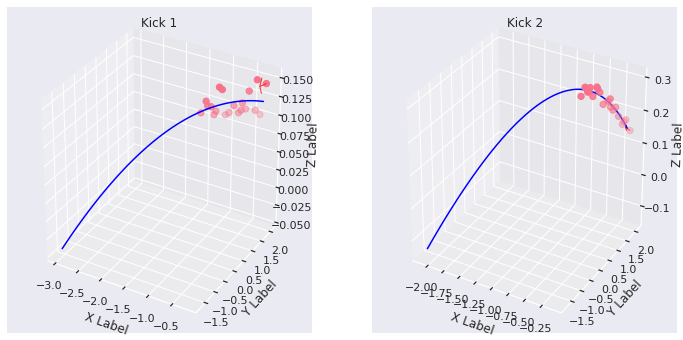

In [ ]:
#@title Kick 1 & 2 Samples and Estimated Trajectory

plt.figure(figsize=(12, 6))
ax = plt.subplot(121, projection='3d')
plt.title('Kick 1')
plot_trajectory(k1, ax)
sc = ax.plot(*p1p.T, c='blue')

ax = plt.subplot(122, projection='3d')
plt.title('Kick 2')
plot_trajectory(k2, ax)
sc = ax.plot(*p2p.T, c='blue')

### Discussions

In [ ]:
#@title

results = (
  pd.DataFrame([                
    ['kick 1', best_lr_l1, 'linear', *lh1[-1]],
    ['kick 2', best_lr_l2, 'linear', *lh2[-1]],
    ['kick 1', best_lr_p1, f'poly {best_d_p1}', *ph1[-1]],
    ['kick 2', best_lr_p2, f'poly {best_d_p2}', *ph2[-1]]
  ],
  columns=['dataset', 'learning rate', 'features', 'mse x', 'mse y', 'mse z'])
 .groupby(['dataset', 'features',  'learning rate'])
 .mean())

results['total loss'] = results.mean(axis=1)

results

mse x     mse y     mse z  total loss
dataset features learning rate                                          
kick 1  linear   1.5            0.000359  0.000057  0.000097    0.000171
        poly 2   1.5            0.000326  0.000111  0.000104    0.000180
kick 2  linear   1.5            0.000123  0.000057  0.000146    0.000109
        poly 2   1.0            0.000186  0.000120  0.000076    0.000127

The first kick dataset seems to map a linear movement of the ball, in which the variation along the $z$-axis is residual. This is either evidence (a) that the $z$-axis measurements observed correspond to noise and the ball is rolling on the ground or (b) these measurements correspond to a small fraction of the movement observations, in which a globally curvilinear movement appears linear.

* Assuming the ball is coiciding with the $xy$ plane: based solely on MSE, the employment of polynomial features is unjustified, as it does not improve upon the solution (i.e., does not provide a reduction in the total sum of *MSEs*).

* Assuming the ball is traveling mid-air: we know that the gravitational force will pull the ball torwards the ground ($z=0$). It is therefore unreasonable to assume $z$ will maintain its current value indefinitely.

For the purposes of this exercise, we assume the first option to be the correct described movement.

If the proportions shown in Fig. 1 of the Assignment are correct, then this kick will not enter on the goal. Hence it does not necessarily have to be defended. Notwithstanding, our model took 47.7 ms to train and 652 µs to predict samples in the set, requiring us to cover 2.2888 meters in 0.3183 s to be able to defend it.

In [ ]:
#@title

near_goal = p1l[:, 1] > 0
near_goal_x = np.where(near_goal)[0][-1]

print(f'goal hit position = {p1l[near_goal_x]}')
print(f'goal hit time     = {x[near_goal_x].item():.4f} s')
print(f'time left to def  = {x[near_goal_x].item() - 1/3:.4f} s')
print(f'required movement = {p1l[near_goal_x, 0]:.4f} (x-axis)')

goal hit position = [-2.28877229  0.00532114  0.10406351]
goal hit time     = 0.7000 s
time left to def  = 0.3667 s
required movement = -2.2888 (x-axis)


The second kick dataset clearly describes a curvilinear movement along the $z$-axis. Employing polynomial features of degree 2 produces a significant MSE improvement over this axis (from $0.000146$ to $0.0000761$), while significantly increasing error along the $y$ axis.
Considering agents will not perform bending kicks, we conclude that the most accurate estimation is obtained when linearly regressing the $x$ and $y$ axes, while regressing the $z$ axis with a second order polynomial.

Our model took 42.3 ms to train and 652 µs to predict samples in the set. Hence we need to cover 1.1541 meters in 0.3249 s to be able to defend it.

In [ ]:
#@title

near_goal = p2p[:, 1] > 0
near_goal_x = np.where(near_goal)[0][-1]

print(f'goal hit position = {p2p[near_goal_x]}')
print(f'goal hit time     = {x[near_goal_x].item():.4f} s')
print(f'time left to def  = {x[near_goal_x].item() - 1/3:.4f} s')
print(f'required movement = {p2p[near_goal_x, 0]:.4f} (x-axis)')

goal hit position = [-1.1541088   0.01624548  0.22994516]
goal hit time     = 0.6167 s
time left to def  = 0.2833 s
required movement = -1.1541 (x-axis)


## Part II

### Digits Dataset

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split


digits = datasets.load_digits()

x, x_test, y, y_test = train_test_split(
  digits.data,
  digits.target,
  test_size=Config.digits.test_size,
  random_state=Config.digits.test_seed
)

CLASSES = [f'digit {i}' for i in digits.target_names]

In [ ]:
def describe(tag, features, labels):
  print(tag)
  print('  samples:', features.shape[0])
  print('  features:', features.shape[1])
  print('  labels:', *np.unique(labels))


describe('train', x, y)
describe('test', x_test, y_test)

train
  samples: 1617
  features: 64
  labels: 0 1 2 3 4 5 6 7 8 9
test
  samples: 180
  features: 64
  labels: 0 1 2 3 4 5 6 7 8 9


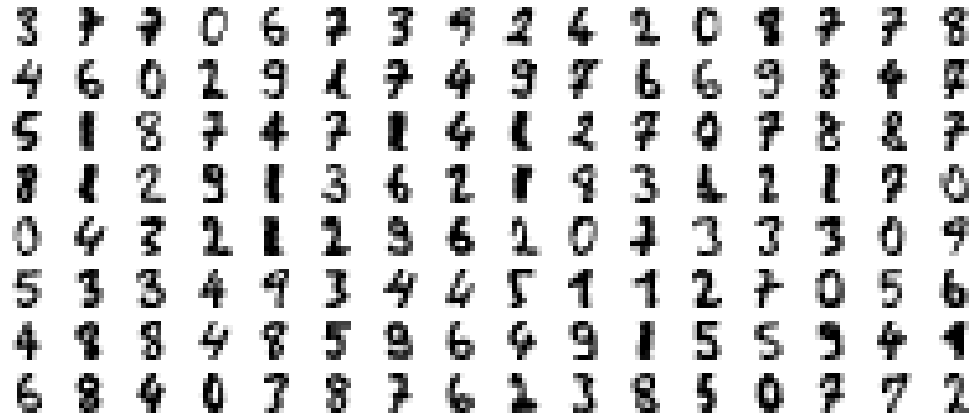

In [ ]:
visualize_images(x[:128].reshape(-1, 8, 8, 1), rows=8, cmap='binary')

### Preprocessing

In [ ]:
from sklearn.decomposition import PCA


z = normalize(x, axis=None)
z_test = normalize(x_test, axis=None)

encoder = PCA(n_components=Config.digits.reducer_components)

z = encoder.fit_transform(z)
z_test = encoder.transform(z_test)

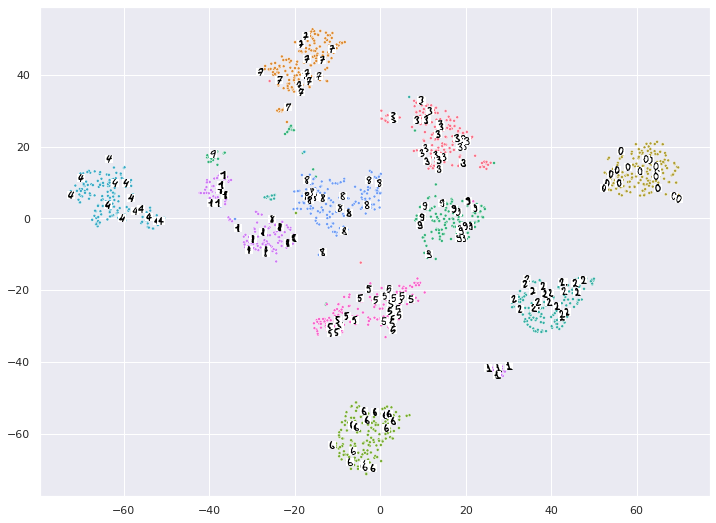

In [ ]:
#@title Digits Dataset (embedded with TSNE)

IMAGES_PLOTTED = None

from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

w = TSNE().fit_transform(np.concatenate((z, z_test), axis=0))
w, w_test = w[:z.shape[0]], w[z.shape[0]:]

fig = plt.figure(figsize=(12, 9))

ax = sns.scatterplot(x=w[:, 0], y=w[:, 1], hue=y.astype(str), marker='.', label='training', legend=False)
ax = sns.scatterplot(x=w_test[:, 0], y=w_test[:, 1], hue=y_test.astype(str), marker='o', label='testing', legend=False)

for pos, sample_image in zip(w_test[:IMAGES_PLOTTED], x_test[:IMAGES_PLOTTED].reshape(-1, 8, 8)):
  ab = AnnotationBbox(OffsetImage(sample_image, cmap='binary'), (pos[0], pos[1]), frameon=False)
  ax.add_artist(ab);

### Linear Support Vector Machine

In [ ]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

config = Config.digits.estimators[0]

print(f'Training {config["model_cls"].__name__} with the following parameters:')

svc_grid = GridSearchCV(
  config['model_cls'](),
  config['search_params'],
  scoring=Config.digits.search_scoring,
  cv=RepeatedStratifiedKFold(
    n_splits=config['search_splits'],
    n_repeats=config['search_repeats']
  ),
  n_jobs=Config.digits.search_jobs,
  verbose=2
).fit(z, y)

Training LinearSVC with the following parameters:
Fitting 100 folds for each of 10 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   17.3s finished


In [ ]:
#@title 10-2-Fold Cross-Validation Results for Linear SVM

(pd.DataFrame({k:v for k, v in svc_grid.cv_results_.items() if 'split' not in k})
   .sort_values('rank_test_score')
   .head()
   .round(4))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_dual,params,mean_test_score,std_test_score,rank_test_score
7,0.0369,0.0033,0.0023,0.0008,0.464159,False,"{'C': 0.46415888336127725, 'dual': False}",0.9568,0.0055,1
8,0.0392,0.0041,0.0022,0.0004,2.15443,False,"{'C': 2.154434690031882, 'dual': False}",0.9537,0.0063,2
6,0.0351,0.0042,0.0022,0.0005,0.1,False,"{'C': 0.1, 'dual': False}",0.9534,0.0056,3
9,0.0465,0.0050,0.0022,0.0005,10,False,"{'C': 10.0, 'dual': False}",0.9472,0.0072,4
5,0.0321,0.0025,0.0022,0.0006,0.0215443,False,"{'C': 0.021544346900318822, 'dual': False}",0.9425,0.0067,5


In [ ]:
params = svc_grid.best_estimator_.get_params()
name_len = max(map(len, params.keys()))

print('Best params found:', *(f'{f.ljust(name_len)} = {v}' for f, v in params.items()), sep='\n  ')

Best params found:
  C                 = 0.46415888336127725
  class_weight      = None
  dual              = False
  fit_intercept     = True
  intercept_scaling = 1
  loss              = squared_hinge
  max_iter          = 1000
  multi_class       = ovr
  penalty           = l2
  random_state      = None
  tol               = 0.0001
  verbose           = 0


#### Explaining

Let $x$ be the input data and $w$ the coefficients of the Support Vector Machine.  
The entire classification pipeline can be described by:

\begin{align}
z &= \frac{x - \min(x)}{\max(x) -\min(x)}\\
l &= z \cdot w^\intercal
\end{align}

Hence the importance of each pixel $(i,j)$ for the classification of unit $u$ is given by $w^\intercal_{ij}$.

Furthermore, if PCA is used to preprocess the input data (where $c$ is the matrix of principal components), then the output is given by two linear transformations in sequence. In this case, the feature contributions can be summarized in $c^\intercal \cdot w^\intercal$, and the CAM becomes $(c^\intercal \cdot w^\intercal)_{ij}$

In [ ]:
svc = svc_grid.best_estimator_

w = encoder.components_.T @ svc.coef_.T  # with PCA encoder
# w = svc.coef_.T                        # without PCA encoder
w = w.T.reshape(10, 8, 8, 1)

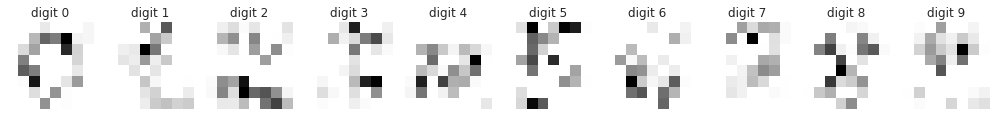

In [ ]:
#@title Positively Contributing Regions for each Class
visualize_images(np.maximum(0., w), CLASSES, rows=1, cmap='binary')

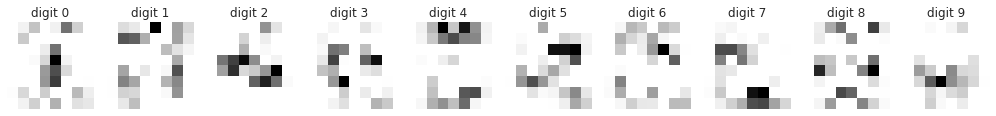

In [ ]:
#@title Negatively Contributing Regions for each Class
visualize_images(np.maximum(0., -w), CLASSES, rows=1, cmap='binary')

#### Evaluation

In [ ]:
from sklearn import metrics


def evaluate(images, features, target, predicted):

  print('Classification Report')
  print(metrics.classification_report(target, predicted))

  cm = metrics.confusion_matrix(target, predicted)
  cm_rate = cm / cm.sum(axis=0, keepdims=True)

  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  sns.heatmap(cm, cmap='RdPu', cbar=False, annot=True)

  plt.subplot(122)
  sns.heatmap(cm_rate, cmap='RdPu', cbar=False, annot=True, fmt='.0%');

  misses = predicted != target

  visualize_images(
    images[misses].reshape(-1, 8, 8, 1),
    [f'true:{a}\npred:{b}' for a, b in zip(target[misses], predicted[misses])],
    cmap='binary',
    rows=1,
    cols=10,
    figsize=(9, 2))
  plt.suptitle('Samples Incorrectly Classified')

  return predicted

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.94      0.94      0.94        18
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        24
           4       0.93      1.00      0.96        13
           5       1.00      1.00      1.00        25
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        14
           8       1.00      0.94      0.97        16
           9       0.94      1.00      0.97        16

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



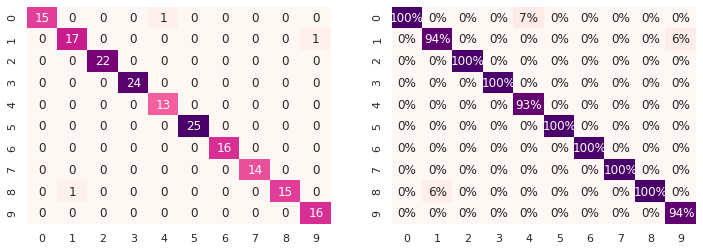

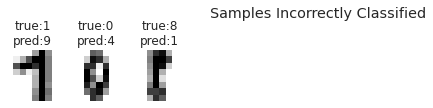

In [ ]:
evaluate(x_test, z_test, y_test, svc.predict(z_test));

#### Discussions

During training, the parameter `C=0.4642` was found to be the configuration that best generalized the model to validation data. `dual=False` was used considering the amount of samples (1617) is larger than the amount of features (64).

The 98% macro (and weighted) F1 test scores explicit that the linear SVM model was indeed able to learn useful patterns to discern digits in the Digits Dataset.
However, we also noticed how single mistakes can drop recall by large quantities (6% for digits `0`, `1` and `8`). This is a sign that this test set is too small for a stable evaluation and/or comparsion of classifiers, and making decisions over these results entail great risk.

In the test set, only three samples amongst all of the 180 test samples were incorrectly classified. We describe which features lead the model to its incorrect conclusions.

* The first sample (digit `1`) was classified as a `9` for having a white vertical central line (samples of `1`s are expected to have this region filled with black). Furthermore, is prominent "hat" covers most of the top of the image, which complies with the pattern used by the model to match the digit `9`.
* The second mistake (ground-truth `0`, predicted as `4`) does not have a strong black stroke on its middle-top region, which could have been used by the model to refute its attribution to the class `4`.
* The last sample (ground-truth `8`, predicted as `1`) is a very unusual draw of the character `8`, making it an arguably understandable mistake by the digit `1`.

### Random Forest Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

config = Config.digits.estimators[1]

print(f'Training {config["model_cls"].__name__} with the following parameters:')

rf_grid = GridSearchCV(
  config['model_cls'](),
  config['search_params'],
  scoring=Config.digits.search_scoring,
  cv=RepeatedStratifiedKFold(
    n_splits=config['search_splits'],
    n_repeats=config['search_repeats']
  ),
  n_jobs=Config.digits.search_jobs,
  verbose=2
).fit(z, y)

Training RandomForestClassifier with the following parameters:
Fitting 100 folds for each of 12 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  4.7min finished


In [ ]:
#@title 10-2-Fold Cross-Validation Results for RF

(pd.DataFrame({k:v for k, v in rf_grid.cv_results_.items() if 'split' not in k})
   .sort_values('rank_test_score')
   .head()
   .round(4))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,mean_test_score,std_test_score,rank_test_score
3,1.2443,0.0152,0.0588,0.0033,None,200,"{'max_depth': None, 'n_estimators': 200}",0.9612,0.0072,1
2,0.6228,0.0096,0.0305,0.0020,None,100,"{'max_depth': None, 'n_estimators': 100}",0.9579,0.0078,2
1,0.3150,0.0098,0.0168,0.0011,None,50,"{'max_depth': None, 'n_estimators': 50}",0.9512,0.0089,3
11,0.9310,0.0158,0.0525,0.0040,5,200,"{'max_depth': 5, 'n_estimators': 200}",0.9248,0.0111,4
10,0.4687,0.0093,0.0289,0.0035,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.9196,0.0119,5


In [ ]:
params = rf_grid.best_estimator_.get_params()
name_len = max(map(len, params.keys()))

print('Best params found:', *(f'{f.ljust(name_len)} = {v}' for f, v in params.items()), sep='\n  ')

Best params found:
  bootstrap                = True
  ccp_alpha                = 0.0
  class_weight             = None
  criterion                = gini
  max_depth                = None
  max_features             = auto
  max_leaf_nodes           = None
  max_samples              = None
  min_impurity_decrease    = 0.0
  min_impurity_split       = None
  min_samples_leaf         = 1
  min_samples_split        = 2
  min_weight_fraction_leaf = 0.0
  n_estimators             = 200
  n_jobs                   = None
  oob_score                = False
  random_state             = None
  verbose                  = 0
  warm_start               = False


#### Explaining

Finding the CAM for Random Forest models is considerably more troublesome than for linear ones such as SVMs, as many sub-classifiers weight in over the decision function --- each considering its own subset of features.

We can infer, from the `feature_importances_` property, that the first 10 features extracted by PCA are used almost 70% of the trees. Thus they are the most commonly used to discriminate between digits.

We can propagate this importance ratio to the principal components, and finally to the original features, resulting in an importance map in the original feature space.
Unfortunatelly, only the absolute overall contributions can be inferred from this visualization.

In [ ]:
rf = rf_grid.best_estimator_
w = rf.feature_importances_

w = np.abs(encoder.components_.T * w)[:, :10].max(axis=-1)  # with PCA encoder
w = w.reshape(-1, 8, 8, 1)

In [ ]:
rf.feature_importances_[:10].sum().round(4)

0.6771

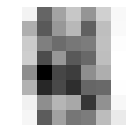

In [ ]:
#@title Most Absolute Contributing Regions

visualize_images(
  w,
  rows=1, cmap='binary',
  figsize=(2, 2))

#### Evaluation

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.95      1.00      0.97        18
           2       0.96      1.00      0.98        22
           3       1.00      1.00      1.00        24
           4       0.87      1.00      0.93        13
           5       1.00      0.96      0.98        25
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        14
           8       1.00      0.88      0.93        16
           9       1.00      1.00      1.00        16

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



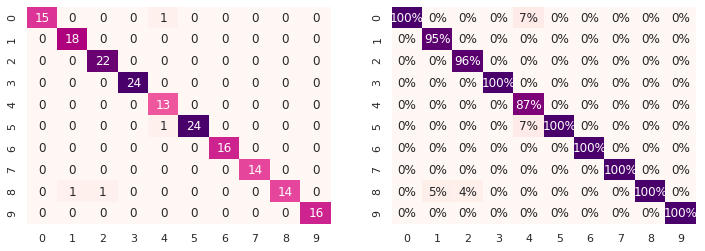

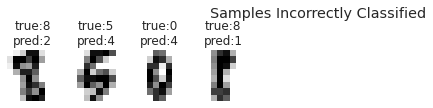

In [ ]:
evaluate(x_test, z_test, y_test, rf.predict(z_test));

#### Discussions

During training, the configuration that best generalized the model to validation data was `n_estimators=200 max_depth=None`. The number of trees (first hyperparameter) seems to have low impact on the results. The maximum depth of each tree, however, strongly impacts the f1-score over the validation splits (reducing it by at least 2.71 percentual points, on average).

Once again, we observe a macro (and weighted) F1 test score of 98%.
However, four test samples were incorrectly classified:

* Digit `8`, classified as `2`
* Digit `5`, classified as `4`
* Digit `0`, classified as `4`
* Digit `8`, classified as `1`

In which two of these are the same misclassified by the Linear Support Vector Machine model.